### Prepare data for fine-tuning Latex-OCR

In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir -p /content/LaTeX-OCR
os.chdir("/content/LaTeX-OCR")

In [ ]:
df_train = pd.read_json("/data/datafiles/train_data.json")
df_t1 = df_train[["image_name","formula"]].sort_values(by="image_name")

In [ ]:
df_t1["formula"].to_csv("/ocr/data/train_data_ocr.txt",header=False, index=False)

In [ ]:
df_valid = pd.read_json("/ocr/data/valid_data.json")
df_v1 = df_valid[["image_name","formula"]].sort_values(by="image_name")

In [ ]:
df_v1["formula"].to_csv("/ocr/data/valid_data_ocr.txt",header=False, index=False)

In [ ]:
!pip install pix2tex[train] -qq

In [ ]:
!pip install gpustat -q
!pip install opencv-python-headless==4.1.2.30 -U -q
!pip install --upgrade --no-cache-dir gdown -q

In [ ]:
os.chdir("/content/LaTeX-OCR")

!mkdir -p dataset/data
!mkdir images
# Google Drive ids
# handwritten: 13vjxGYrFCuYnwgDIUqkxsNGKk__D_sOM
# pdf - images: 176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
# pdf - math: 1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D
!gdown -O dataset/data/crohme.zip --id 13vjxGYrFCuYnwgDIUqkxsNGKk__D_sOM
!gdown -O dataset/data/pdf.zip --id 176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
!gdown -O dataset/data/pdfmath.txt --id 1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D

os.chdir('dataset/data')
!mkdir my_train
!mkdir my_valid
!mkdir my_test

!unzip -q crohme.zip
!unzip -q pdf.zip
# split handwritten data into val set and train set
os.chdir('images')
!mkdir ../valimages
!ls | shuf -n 1000 | xargs -i mv {} ../valimages
os.chdir('../../..')

In [ ]:
cp /ocr/data/train_data_ocr.txt /content/LaTeX-OCR/dataset/data

In [ ]:
cp /ocr/data/valid_data_ocr.txt /content/LaTeX-OCR/dataset/data

### Copy Images

In [ ]:
TRAIN_IMG_DIR = os.path.dirname("/content/LaTeX-OCR/dataset/data/my_train/")
VALID_IMG_DIR = os.path.dirname("/content/LaTeX-OCR/dataset/data/my_valid/")
TEST_IMG_DIR = os.path.dirname("/content/LaTeX-OCR/dataset/data/my_test/")

In [ ]:
cp /content/drive/MyDrive/data/my_image_corpus/train/* /content/LaTeX-OCR/dataset/data/my_train/

In [ ]:
cp /content/drive/MyDrive/data/my_image_corpus/valid/* /content/LaTeX-OCR/dataset/data/my_valid/

In [ ]:
cp /content/drive/MyDrive/data/my_image_corpus/test/* /content/LaTeX-OCR/dataset/data/my_test/

In [ ]:
def rename_filenames_to_intnames(directory):
  counter = 1
  files = os.listdir(directory)
  files.sort()

  for filename in files:
      if filename.endswith('.png'):
          new_filename = str(counter).zfill(7) + '.png'
          os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
          counter += 1

In [ ]:
rename_filenames_to_intnames(TRAIN_IMG_DIR)
rename_filenames_to_intnames(VALID_IMG_DIR)
rename_filenames_to_intnames(TEST_IMG_DIR)

### Images paden

The images need to be preprocessed in a way that the dimensions of every image can be divisible by the patch size

In [ ]:
from pix2tex import utils
from PIL import Image

In [ ]:
def pad_images(directory):

  for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_path = os.path.join(directory, filename)
            try:
                with Image.open(file_path) as img:
                    #print("Org-size: ", img.size)
                    img_pad = utils.pad(img)
                    #print("New-size: ", img_pad.size)
                    img_pad.save(file_path)
            except (IOError, OSError):
                print(f"Failed to process file: {file_path}")

In [ ]:
pad_images(TRAIN_IMG_DIR)

In [ ]:
pad_images(VALID_IMG_DIR)

In [ ]:
pad_images(TEST_IMG_DIR)

### Check image size

In [ ]:
def get_image_sizes(directory):
    image_sizes = {}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more formats if needed
            file_path = os.path.join(directory, filename)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    image_sizes[filename] = (width, height)
            except (IOError, OSError):
                print(f"Failed to open file: {file_path}")
    return image_sizes

In [ ]:
os.chdir("/content/LaTeX-OCR/")

In [ ]:
!python -m pix2tex.dataset.dataset -i dataset/data/images dataset/data/train dataset/data/my_train -e dataset/data/CROHME_math.txt dataset/data/pdfmath.txt dataset/data/train_data_ocr.txt -o dataset/data/train.pkl

In [ ]:
cp dataset/data/train.pkl /content/drive/MyDrive/models/LaTeX-OCR/

In [ ]:
!python -m pix2tex.dataset.dataset -i dataset/data/valimages dataset/data/val dataset/data/my_valid -e dataset/data/CROHME_math.txt dataset/data/pdfmath.txt dataset/data/valid_data_ocr.txt -o dataset/data/val.pkl

In [ ]:
cp dataset/data/val.pkl /content/drive/MyDrive/models/LaTeX-OCR/

In [ ]:
# download the weights we want to fine tune
!curl -L -o weights.pth https://github.com/lukas-blecher/LaTeX-OCR/releases/download/v0.0.1/weights.pth

In [ ]:
# If using wandb - cancel this if you don't wan't to use it or don't have a W&B acc.
!pip install -q wandb

In [ ]:
os.chdir("/content/LaTeX-OCR/")

In [ ]:
# generate colab specific config (set 'debug' to true if wandb is not used)
!echo {backbone_layers: [2, 3, 7], betas: [0.9, 0.999], batchsize: 40, bos_token: 1, channels: 1, data: dataset/data/train.pkl, debug: true, decoder_args: {'attn_on_attn': true, 'cross_attend': true, 'ff_glu': true, 'rel_pos_bias': false, 'use_scalenorm': false}, dim: 256, encoder_depth: 4, eos_token: 2, epochs: 10, gamma: 0.9995, heads: 8, id: null, load_chkpt: 'weights.pth', lr: 0.001, lr_step: 30, max_height: 192, max_seq_len: 512, max_width: 672, min_height: 32, min_width: 32, model_path: checkpoints, name: LaTeX-OCR-tuned-cf-allnew, num_layers: 4, num_tokens: 8000, optimizer: Adam, output_path: outputs, pad: false, pad_token: 0, patch_size: 16, sample_freq: 2000, save_freq: 1, scheduler: StepLR, seed: 42, temperature: 0.2, test_samples: 5, testbatchsize: 20, tokenizer: dataset/tokenizer.json, valbatches: 100, valdata: dataset/data/val.pkl} > colab.yaml

In [ ]:
!python -m pix2tex.train --config colab.yaml

### Model Test

In [ ]:
import os
import PIL

!pip install Pillow -U -qq
if int(PIL.__version__[0]) < 9:
    print('Mandatory restart: Execute this cell again!')
    import os
    os.kill(os.getpid(), 9)

In [ ]:
!pip install pix2tex -qq
!pip install opencv-python-headless==4.1.2.30 -U -qq

In [ ]:
from pix2tex import cli as pix2tex
from PIL import Image

In [ ]:
model = pix2tex.LatexOCR()

In [ ]:
model.args

Munch({'epoch': 0, 'gpu_devices': [], 'backbone_layers': [2, 3, 7], 'betas': [0.9, 0.999], 'batchsize': 64, 'bos_token': 1, 'channels': 1, 'data': 'dataset/data/train.pkl', 'debug': False, 'decoder_args': {'attn_on_attn': True, 'cross_attend': True, 'ff_glu': True, 'rel_pos_bias': False, 'use_scalenorm': False}, 'dim': 256, 'encoder_depth': 4, 'eos_token': 2, 'epochs': 10, 'gamma': 0.9995, 'heads': 8, 'id': None, 'load_chkpt': None, 'lr': 0.001, 'lr_step': 30, 'max_height': 192, 'max_seq_len': 512, 'max_width': 672, 'micro_batchsize': -1, 'min_height': 32, 'min_width': 32, 'model_path': 'checkpoints', 'name': 'pix2tex', 'num_layers': 4, 'num_tokens': 8000, 'optimizer': 'Adam', 'output_path': 'outputs', 'pad': False, 'pad_token': 0, 'patch_size': 16, 'sample_freq': 3000, 'save_freq': 5, 'scheduler': 'StepLR', 'seed': 42, 'encoder_structure': 'hybrid', 'temperature': 0.2, 'test_samples': 5, 'testbatchsize': 20, 'tokenizer': 'dataset/tokenizer.json', 'valbatches': 100, 'valdata': 'dataset

In [ ]:
from munch import Munch

In [ ]:
arguments = Munch(config='/content/drive/MyDrive/models/LaTeX-OCR/my_model_path/LaTeX-OCR-tuned-cf-allnew/config.yaml', checkpoint='/content/drive/MyDrive/models/LaTeX-OCR/my_model_path/LaTeX-OCR-tuned-cf-allnew/LaTeX-OCR-tuned-cf-allnew_e06_step4144.pth', t=0.20, no_cuda=True, no_resize=True)

In [ ]:
my_model = pix2tex.LatexOCR(arguments)

In [ ]:
my_model.args

Munch({'epoch': 9, 'backbone_layers': [2, 3, 7], 'batchsize': 40, 'betas': [0.9, 0.999], 'bos_token': 1, 'channels': 1, 'config': '/content/drive/MyDrive/models/LaTeX-OCR/my_model_path/LaTeX-OCR-tuned-cf-allnew/config.yaml', 'data': 'dataset/data/train.pkl', 'debug': False, 'decoder_args': {'attn_on_attn': True, 'cross_attend': True, 'ff_glu': True, 'rel_pos_bias': False, 'use_scalenorm': False}, 'device': 'cpu', 'dim': 256, 'encoder_depth': 4, 'encoder_structure': 'hybrid', 'eos_token': 2, 'epochs': 10, 'gamma': 0.9995, 'gpu_devices': [0], 'heads': 8, 'id': 'e0ici28p', 'load_chkpt': None, 'lr': 0.001, 'lr_step': 30, 'max_dimensions': [672, 192], 'max_height': 192, 'max_seq_len': 512, 'max_width': 672, 'min_dimensions': [32, 32], 'min_height': 32, 'min_width': 32, 'model_path': 'my_model_path', 'name': 'LaTeX-OCR-tuned-cf-allnew', 'no_cuda': True, 'num_layers': 4, 'num_tokens': 8000, 'optimizer': 'Adam', 'output_path': 'outputs', 'pad': False, 'pad_token': 0, 'patch_size': 16, 'resume'

Prediction:  R^{(5)}=-{\frac{2}{l^{2}}}
Image:


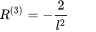

In [ ]:
pic1 = Image.open("/content/drive/MyDrive/models/LaTeX-OCR/data/my_test/0000001.png")
print("Prediction: ", my_model(pic1))
print("Image:")
pic1

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score sacrebleu jiwer

In [ ]:
from google.colab import files

In [ ]:
!cp /utils/cf_custom_functions.py /content

In [ ]:
import cf_custom_functions as cf
import pandas as pd
import numpy as np
import evaluate

In [ ]:
df_test = cf.load_test_data("/data/datafiles/test_data.json")

In [ ]:
IMG_DIR = "data/images_formulas/"
y_preds = []
i = 0
for img in df_test.iterrows():
  image = Image.open(IMG_DIR+img[1]["image_name"])
  img_path = IMG_DIR+img[1]["image_name"]
  img_pad = utils.pad(image)
  math = my_model(img_pad)
  y_preds.append(math)
  i = i+1

y_preds = np.array(y_preds)
df_test["prediciton"] = y_preds

In [ ]:
df_test.to_csv("../predictions/LaTeX-OCR-fine-tuned_predictions.csv")